# Is random imputation always better than deterministic imputation?
According to Gelman & Hill Data Analysis Using Regression and Multilevel/Hierarchical Models, chapter 25.4 it is good to add noise with standard deviation of the residual to not falsely assume deterministic imputation, and use random imputation instead. My intuition is that although the distribution of imputed variable $x$ might be a better approximation of the true distribution of the true (non-missing) $x$, this is not always a good idea. The problem that the noise introduced is totally uncorrelated with outcome $x$ and therefore biasing your estimate $\beta$ towards 0, similar to measurement error bias / attenuation bias / regression dilution.

In [163]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install pandas

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import seaborn as sns
import pandas as pd

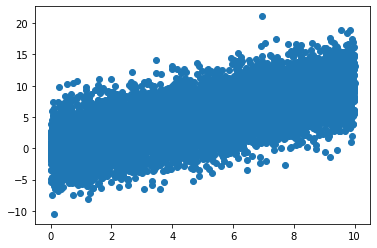

In [165]:
beta_0 = 0
beta_1 = 1
n = 10000
stdev_noise = 3
noise = np.random.normal(0, stdev_noise, n)
c = np.ones(n)
x_1 = np.random.uniform(0,10, n)
y = c * beta_0 + x_1 * beta_1 + noise
y = y.reshape((-1,1))
X = np.c_[c, x_1]
plt.scatter(x_1,y)

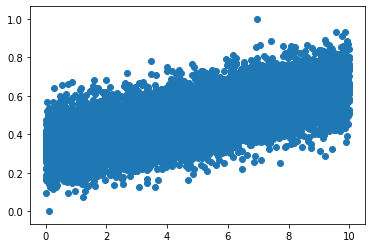

In [166]:
# y_scaled = (y-min(y))/max(y-min(y))
# plt.scatter(x_1,y_scaled)

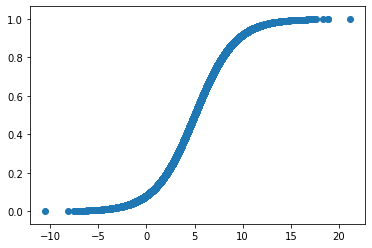

In [167]:
amount_of_dependancy_missing_on_y = 2
y_scaled = (y - np.mean(y)) / np.std(y) * amount_of_dependancy_missing_on_y
plt.scatter(y,scipy.stats.logistic.cdf(y_scaled))

In [168]:
probability_missing = 0.5
missing = np.random.binomial(1,probability_missing, n)
Xmissing_random = pd.DataFrame(X.copy())
Xmissing_random[1][missing==1] = np.NaN

missing = np.random.binomial(1,scipy.stats.logistic.cdf(y_scaled))
Xm = pd.DataFrame(X.copy())
Xm[1][missing.flatten()==1] = np.NaN

### with the real data

In [169]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     9335.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:51:15   Log-Likelihood:                -25119.
No. Observations:               10000   AIC:                         5.024e+04
Df Residuals:                    9998   BIC:                         5.026e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0674      0.059      1.138      0.2

### with the data missing at random

In [170]:
mod = sm.OLS(y[~Xmissing_random[1].isna()], Xmissing_random[~Xmissing_random[1].isna()])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     4522.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:51:15   Log-Likelihood:                -12706.
No. Observations:                5054   AIC:                         2.542e+04
Df Residuals:                    5052   BIC:                         2.543e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1857      0.084      2.222      0.0

### with the probability of missing x depending on y

In [171]:
mod = sm.OLS(y[~Xm[1].isna()], Xm[~Xm[1].isna()])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     2795.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:51:15   Log-Likelihood:                -11863.
No. Observations:                4997   AIC:                         2.373e+04
Df Residuals:                    4995   BIC:                         2.374e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3126      0.064     -4.876      0.0

### make a model to predict x based on y for imputing

In [172]:
mod = sm.OLS(Xm[1][~Xm[1].isna()], y[~Xm[1].isna()])
result = mod.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      1   R-squared (uncentered):                   0.591
Model:                            OLS   Adj. R-squared (uncentered):              0.591
Method:                 Least Squares   F-statistic:                              7226.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):                        0.00
Time:                        12:51:15   Log-Likelihood:                         -12408.
No. Observations:                4997   AIC:                                  2.482e+04
Df Residuals:                    4996   BIC:                                  2.482e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Estimate using deterministic imputation

In [173]:
x_to_impute = result.predict(y[Xm[1].isna()])
Ximputed = Xm.copy()
Ximputed[1][Xm[1].isna()] = x_to_impute.copy()

mod = sm.OLS(y, Ximputed)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                 2.545e+04
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:51:15   Log-Likelihood:                -22088.
No. Observations:               10000   AIC:                         4.418e+04
Df Residuals:                    9998   BIC:                         4.419e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.8662      0.043    -20.173      0.0

### Now do random imputation

In [174]:
x_to_impute = result.predict(y[Xm[1].isna()]) \
            + np.random.normal(0, np.power(result.mse_resid,0.5), len(y[Xm[1].isna()]))
Ximputed = Xm.copy()
Ximputed[1][Xm[1].isna()] = x_to_impute.copy()

mod = sm.OLS(y, Ximputed)
res2 = mod.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     9891.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:51:15   Log-Likelihood:                -24977.
No. Observations:               10000   AIC:                         4.996e+04
Df Residuals:                    9998   BIC:                         4.997e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.9607      0.050     19.115      0.0

###  $\beta_1$ seems to be biased towards 0!

### findings:
* we do observe the missing variables bias
* deterministic imputation seems to result in an overestimate of $\beta_1$
* random imputation on the other hand seems to underestimate $\beta_1$
* in general shrinkage towards 0 because of random impuat

### Appendix: using the method for adding a variable for missingness

In [175]:
Xcorrected = Xm.copy()
Xcorrected[1][Xm[1].isna()] = 0
Xcorrected['missing'] = 0
Xcorrected.loc[Xm[1].isna(), 'missing'] = 1

mod = sm.OLS(y, Xcorrected)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     4751.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:51:15   Log-Likelihood:                -25076.
No. Observations:               10000   AIC:                         5.016e+04
Df Residuals:                    9997   BIC:                         5.018e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3126      0.073     -4.266      0.0